In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torchvision import transforms
from PIL import Image

import os
import csv
import numpy as np
import glob

from sklearn.metrics import accuracy_score, f1_score

In [2]:
import csv
from tqdm import tqdm

label_dict = {}
with open("../ComParE2017_Cold_4students/lab/ComParE2017_Cold.tsv", "r", encoding="utf-8") as f:
    reader = csv.DictReader(f, delimiter="\t")
    rows = list(reader)
    for row in tqdm(rows, desc="Loading labels"):
        label_dict[row["file_name"]] = row["Cold (upper respiratory tract infection)"]

Loading labels: 100%|██████████| 19101/19101 [00:00<00:00, 4775311.48it/s]


In [3]:
import os
def search_in_labels(filename, label_dict):
    base_name = os.path.splitext(filename)[0]
    
    if "_logmel" in base_name:
        base_name = base_name.replace("_logmel", "")
    if "_flipped" in base_name:
        base_name = base_name.replace("_flipped", "")
    
    parts = base_name.split("_")
    if len(parts) >= 2:
        audio_filename = f"{parts[0]}_{parts[1]}.wav"
    else:
        audio_filename = f"{base_name}.wav"
    
    return label_dict.get(audio_filename, None)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class SpectrogramSequenceClassifier(nn.Module):
    def __init__(self, 
                 cnn_out_dim=512, 
                 sequence_model='transformer',  # 'transformer', 'lstm', 'attention'
                 hidden_dim=256,
                 num_heads=8,
                 num_layers=2,
                 dropout=0.1):
        super().__init__()
        
        # CNN Encoder for each window
        self.cnn_encoder = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Block 3
            nn.Conv2d(32, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((4, 4)),  # 输出 (512, 4, 4)
            
            nn.Flatten(), 
            nn.Linear(4096, cnn_out_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout)
        )
        
        self.sequence_model_type = sequence_model
        self.hidden_dim = hidden_dim
        
        # 序列模型选择
        if sequence_model == 'transformer':
            self.pos_encoding = PositionalEncoding(cnn_out_dim, dropout)
            encoder_layer = nn.TransformerEncoderLayer(
                d_model=cnn_out_dim,
                nhead=num_heads,
                dim_feedforward=hidden_dim,
                dropout=dropout,
                batch_first=True
            )
            self.sequence_model = nn.TransformerEncoder(encoder_layer, num_layers)
            self.global_pool = nn.AdaptiveAvgPool1d(1)  # 全局平均池化
            
        elif sequence_model == 'lstm':
            self.sequence_model = nn.LSTM(
                input_size=cnn_out_dim,
                hidden_size=hidden_dim,
                num_layers=num_layers,
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True,
                bidirectional=True
            )
            lstm_out_dim = hidden_dim * 2  # 双向LSTM
            
        elif sequence_model == 'attention':
            self.sequence_model = SelfAttention(cnn_out_dim, hidden_dim, num_heads, dropout)
            
        # 分类头
        if sequence_model == 'lstm':
            classifier_input_dim = lstm_out_dim
        else:
            classifier_input_dim = cnn_out_dim
            
        self.classifier = nn.Sequential(
            nn.Linear(classifier_input_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(64, 1)  # 二分类
        )
        
    def forward(self, x):
        # x shape: (batch_size, num_windows, channels, height, width)
        batch_size, num_windows, C, H, W = x.shape
        
        # 重塑为 (batch_size * num_windows, C, H, W) 进行CNN编码
        x = x.view(-1, C, H, W)
        
        # CNN 特征提取
        cnn_features = self.cnn_encoder(x)  # (batch_size * num_windows, cnn_out_dim)
        
        # 重塑回序列格式
        cnn_features = cnn_features.view(batch_size, num_windows, -1)  # (batch_size, num_windows, cnn_out_dim)
        
        # 序列建模
        if self.sequence_model_type == 'transformer':
            # 添加位置编码
            x = self.pos_encoding(cnn_features)
            # Transformer编码
            x = self.sequence_model(x)  # (batch_size, num_windows, cnn_out_dim)
            # 全局池化
            x = x.transpose(1, 2)  # (batch_size, cnn_out_dim, num_windows)
            x = self.global_pool(x).squeeze(-1)  # (batch_size, cnn_out_dim)
            
        elif self.sequence_model_type == 'lstm':
            # LSTM编码
            x, (h_n, c_n) = self.sequence_model(cnn_features)
            # 使用最后一个时间步的输出
            x = x[:, -1, :]  # (batch_size, hidden_dim * 2)
            
        elif self.sequence_model_type == 'attention':
            # 自注意力
            x = self.sequence_model(cnn_features)  # (batch_size, cnn_out_dim)
        
        # 分类
        output = self.classifier(x)  # (batch_size, 1)
        return output

# 位置编码（用于Transformer）
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:x.size(1), :].transpose(0, 1)
        return self.dropout(x)

# 自注意力模块
class SelfAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, dropout=0.1):
        super().__init__()
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=input_dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.norm = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # 自注意力
        attn_output, attn_weights = self.multihead_attn(x, x, x)
        
        # 残差连接和层归一化
        x = self.norm(x + self.dropout(attn_output))
        
        # 全局平均池化
        x = x.mean(dim=1)  # (batch_size, input_dim)
        
        return x

In [5]:
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import Dataset
from PIL import Image
import os
class SequenceSpectrogramDataset(Dataset):
    def __init__(self, image_paths, label_dict, window_size=128, stride=64, 
                 max_windows=10, is_training=True):
        self.image_paths = image_paths
        self.label_dict = label_dict
        self.window_size = window_size
        self.stride = stride
        self.max_windows = max_windows
        self.is_training = is_training
        
        self.transform = transforms.Compose([
            transforms.ToTensor(),
        ])
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        filename = os.path.basename(image_path)
        label = search_in_labels(filename, self.label_dict)
        label_num = 1 if label == "C" else 0
        
        # 加载图像
        image = Image.open(image_path).convert("RGB")
        image_tensor = self.transform(image)
        
        _, H, W = image_tensor.shape
        assert H == 128, f"Image height must be 128, but got {H}"
        
        # 滑动窗口提取
        windows = []
        for start in range(0, W - self.window_size + 1, self.stride):
            window = image_tensor[:, :, start:start + self.window_size]
            windows.append(window)
        
        # 处理最后一个窗口
        if (W - self.window_size) % self.stride != 0:
            last_window = image_tensor[:, :, -self.window_size:]
            windows.append(last_window)
        
        # 确保至少有一个窗口
        if len(windows) == 0:
            pad_width = self.window_size - W
            image_padded = F.pad(image_tensor, (0, pad_width), mode='constant', value=0)
            window = image_padded[:, :, :self.window_size]
            windows.append(window)
        
        # 限制最大窗口数量
        if len(windows) > self.max_windows:
            if self.is_training:
                # 随机选择
                indices = torch.randperm(len(windows))[:self.max_windows]
                windows = [windows[i] for i in indices]
            else:
                # 均匀采样
                indices = torch.linspace(0, len(windows)-1, self.max_windows).long()
                windows = [windows[i] for i in indices]
        
        # 如果窗口不足，进行填充
        while len(windows) < self.max_windows:
            windows.append(windows[-1].clone())  # 复制最后一个窗口
        
        # 堆叠成序列
        windows_tensor = torch.stack(windows)  # (max_windows, 3, 128, 128)
        
        return windows_tensor, label_num

In [6]:
import os
import glob
from torch.utils.data import DataLoader, Dataset


data_split = ["train_files", "devel_files"]
img_dir = "../spectrograms_variable_width"  

def collect_image_paths_devel(split_name):
        sub_dir = os.path.join(img_dir, split_name)
        print(f"🔍 Looking for images in: {sub_dir}")
        
        if not os.path.exists(sub_dir):
            print(f"❌ Directory does not exist: {sub_dir}")
            return []
        
        png_files = glob.glob(os.path.join(sub_dir, "*.png"))
        
        filtered_files = [f for f in png_files if "flipped" not in os.path.basename(f)]
        
        print(f"📁 Found {len(png_files)} PNG files in {split_name}")
        print(f"📋 After filtering out 'flipped' files: {len(filtered_files)} files")
        
        return filtered_files

def collect_image_paths(split_name):
    sub_dir = os.path.join(img_dir, split_name)
    print(f"🔍 Looking for images in: {sub_dir}")
    
    if not os.path.exists(sub_dir):
        print(f"❌ Directory does not exist: {sub_dir}")
        return []
    
    png_files = glob.glob(os.path.join(sub_dir, "*.png"))
    print(f"📁 Found {len(png_files)} PNG files in {split_name}")
    
    return png_files

print("🚀 Collecting image paths...")
train_image_paths = collect_image_paths("train_files")
devel_image_paths = collect_image_paths_devel("devel_files")

train_dataset = SequenceSpectrogramDataset(
    image_paths=train_image_paths,
    label_dict=label_dict,
    window_size=128,
    stride=64,
    max_windows=5,
    is_training=True
)
val_dataset = SequenceSpectrogramDataset(
    image_paths=devel_image_paths,
    label_dict=label_dict,
    window_size=128,
    stride=64,
    max_windows=15, 
    is_training=False
)
train_loader = DataLoader(
    train_dataset,  
    batch_size=32,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,  
    batch_size=32,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)



🚀 Collecting image paths...
🔍 Looking for images in: ../spectrograms_variable_width\train_files
📁 Found 10475 PNG files in train_files
🔍 Looking for images in: ../spectrograms_variable_width\devel_files
📁 Found 10607 PNG files in devel_files
📋 After filtering out 'flipped' files: 9596 files


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score
import tqdm

def evaluate_sequence_model(model, dataloader, device, criterion):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0.0
    num_batches = 0
    
    with torch.no_grad():
        for batch_windows, batch_labels in tqdm.tqdm(dataloader, desc="Evaluating", leave=False):
            batch_windows = batch_windows.to(device)
            batch_labels = batch_labels.to(device)
            
            logits = model(batch_windows).squeeze()
            if logits.dim() == 0:
                logits = logits.unsqueeze(0)
            
            # 计算loss
            loss = criterion(logits, batch_labels.float())
            total_loss += loss.item()
            num_batches += 1
                
            preds = (torch.sigmoid(logits) > 0.5).long()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())
    
    # 计算平均loss
    avg_loss = total_loss / num_batches if num_batches > 0 else 0.0
    
    # 计算指标
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    uar = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    
    return avg_loss, f1, uar, all_labels, all_preds

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_model_path = "../model/best_sequence_model.pth"
model = SpectrogramSequenceClassifier(
    cnn_out_dim=256,
    sequence_model='transformer',
    hidden_dim=128,
    num_heads=4,
    num_layers=1,
    dropout=0.3
).to(device)
if os.path.exists(pretrained_model_path):
    print(f"Loading pretrained model from {pretrained_model_path}")
    model.load_state_dict(torch.load(pretrained_model_path, map_location=device))
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3.5).to(device))  
model.eval()  


Loading pretrained model from ../model/best_sequence_model.pth


SpectrogramSequenceClassifier(
  (cnn_encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): AdaptiveAvgPool2d(output_size=(4, 4))
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=4096, out_features=256, bias=True)
    (14): ReLU(inplace=True)
    (15

In [14]:
avg_loss, f1, uar, val_labels, val_preds = evaluate_sequence_model(
    model, val_loader, device, criterion
)

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, recall_score

uar = recall_score(val_labels, val_preds, average='macro')

print(f"\n📈 PERFORMANCE METRICS:")
print(f"   UAR (Unweighted Average Recall): {uar:.4f}")

if len(set(val_labels)) > 1 and len(set(val_preds)) > 1:
    cm = confusion_matrix(val_labels, val_preds)
    
    class_recalls = []
    for i in range(len(cm)):
        if cm[i].sum() > 0:  
            recall = cm[i, i] / cm[i].sum()
            class_recalls.append(recall)
        else:
            class_recalls.append(0.0)
    
    print(f"\n🎯 PER-CLASS RECALL:")
    class_names = ['Healthy', 'Cold']
    for i, (name, recall) in enumerate(zip(class_names, class_recalls)):
        print(f"   Class {i} ({name}): {recall:.4f}")


📈 PERFORMANCE METRICS:
   UAR (Unweighted Average Recall): 0.5712

🎯 PER-CLASS RECALL:
   Class 0 (Healthy): 0.8950
   Class 1 (Cold): 0.2473


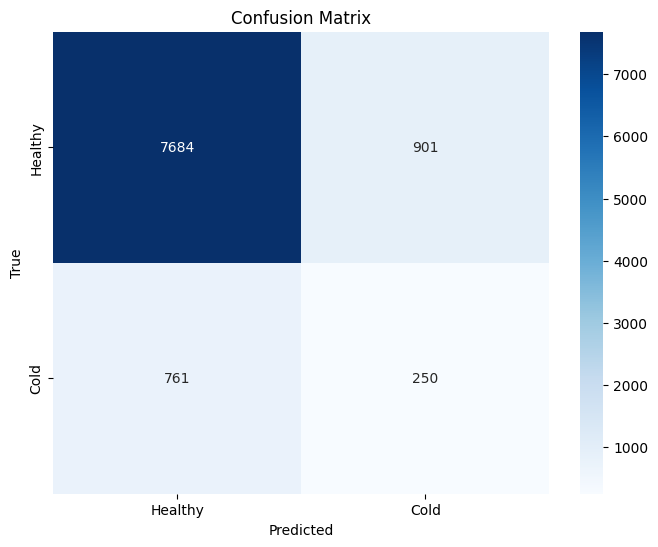

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(cm, class_names=['Healthy', 'Cold'])

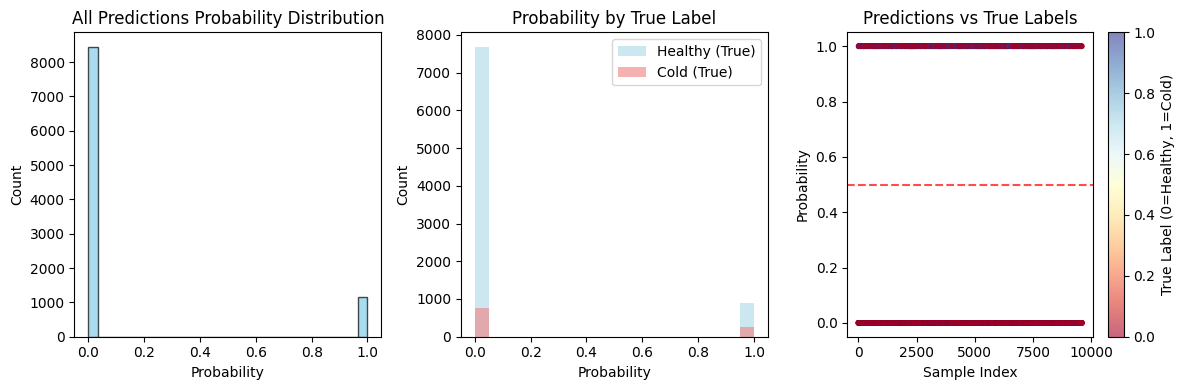

In [17]:
import numpy as np
val_probs = np.array(val_preds)
val_labels = np.array(val_labels)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(val_probs, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('All Predictions Probability Distribution')
plt.xlabel('Probability')
plt.ylabel('Count')

healthy_probs = val_probs[val_labels == 0]
cold_probs    = val_probs[val_labels == 1]

plt.subplot(1, 3, 2)
plt.hist(healthy_probs, bins=20, alpha=0.6, label='Healthy (True)', color='lightblue')
plt.hist(cold_probs,    bins=20, alpha=0.6, label='Cold (True)',    color='lightcoral')
plt.title('Probability by True Label')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(range(len(val_probs)), val_probs, c=val_labels, 
            cmap='RdYlBu', alpha=0.6, s=10)
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7)
plt.title('Predictions vs True Labels')
plt.xlabel('Sample Index')
plt.ylabel('Probability')
plt.colorbar(label='True Label (0=Healthy, 1=Cold)')

plt.tight_layout()
plt.show()